In [1]:
import gdown
import numpy as np
import os
import pandas as pd
import copy

from matplotlib import pyplot as plt

# Data Processing

In [2]:
url = 'https://drive.google.com/u/0/uc?id=19EMDNi6AT4pecx_iWltZv0GxLYqv4Eof&export=download'
output = 'active_and_inconclusive_communities.xlsx'
gdown.download(url, output, quiet=True)

'active_and_inconclusive_communities.xlsx'

In [3]:
df = pd.read_excel("active_and_inconclusive_communities.xlsx", engine='openpyxl')

In [4]:
# Homogenizing column formats
data = copy.deepcopy(df)
data['PropertyName'] = data['PropertyName'].str.upper()
data['PropertyAddress'] = data['PropertyAddress'].str.title()
data['City'] = data['City'].str.title()
data['County'] = data['County'].str.title()
data['Owner'] = data['Owner'].str.upper()
data['ManagerName'] = data['ManagerName'].str.upper()

# Replace state name for Guam
data['State'].loc[data['State']=='WP'] = 'GU'

# Target Tenant Type cleaning
data['TargetTenantType'] = data['TargetTenantType'].str.replace("Eldery or Disabled", "Elderly or Disabled")
data['TargetTenantType'] = data['TargetTenantType'].str.replace("Mixed;Link", "Mixed")
data['TargetTenantType'] = data['TargetTenantType'].str.replace("Indv. families - not eld/ handicap", "Family")
data['TargetTenantType'] = data['TargetTenantType'].str.replace("Senior", "Elderly")
data['TargetTenantType'] = data['TargetTenantType'].str.replace("Family & Elderly", "Mixed")
data['TargetTenantType'] = data['TargetTenantType'].str.replace("Homeless Veterans", "Veterans")
data['TargetTenantType'] = data['TargetTenantType'].str.replace("Mixed Income", "Mixed")
data['TargetTenantType'] = data['TargetTenantType'].str.replace("OTHER", "Mixed")
data['TargetTenantType'] = data['TargetTenantType'].str.replace("Affordable", "Low Income")
data['TargetTenantType'] = data['TargetTenantType'].str.title()

/home/sam/.local/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [5]:
active_subsidy_columns = {c[12:]: c for c in data.columns if c[:12] == 'NumberActive'}

The most generally interesting columns are going to be in the first 43 columns, because the rest are focused on individual subsidies.

In [6]:
with pd.option_context('display.max_rows', None):
    display(data[data.columns[:43]].sample(8).transpose())

,46847,6711,7618,47314,37040,6330,47739,56715
NHPDPropertyID,1084769,1019344,1020280,1085502,1067679,1018954,1086406,1101654
PropertyName,JEFFERSON HEIGHTS,KING CREEK COTTAGES,AMAPOLA HOME,PHFA CHDO - HILL TERRACE,BRIGANTINE HOMES,KENNEDY INSTITUTE HOUSING CORP II,JOHN F KENNEDY MANOR,LIPPERT TERRACE
PropertyAddress,38 W Philadelphia Ave,201 King Creek Blvd,786 Clifford Ave,Hill St,1062 Brigantine Blvd,7606 Marietta Ln,547 Clinton St,4420 Maccorkle Ave Se
City,Boyertown,Hendersonville,Rochester,Lebanon,Atlantic City,Berwyn Heights,Woonsocket,Charleston
State,PA,NC,NY,PA,NJ,MD,RI,WV
Zip,19512-1459,28792-4899,14621-5751,17042,08401-8113,20740-2627,02895-3251,25304-1745
CBSACode,39740,11700,40380,30140,12100,47900,39300,16620
CBSAType,Metropolitan Statistical Area,Metropolitan Statistical Area,Metropolitan Statistical Area,Metropolitan,Metropolitan,Metropolitan Statistical Area,Metropolitan,Metropolitan
County,Berks,Henderson,Monroe,Lebanon,Atlantic,Prince Georges,Providence,Kanawha
CountyCode,42011,37089,36055,42075,34001,24033,44007,54039


## Hillsborough, Orange and Miami-Dade

In [7]:
data_fl3 = data[(data['State'] == 'FL') & (data['County'].isin(['Miami-Dade', 'Hillsborough', 'Orange']))]

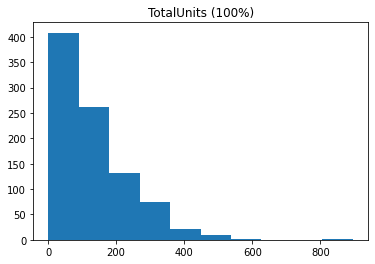

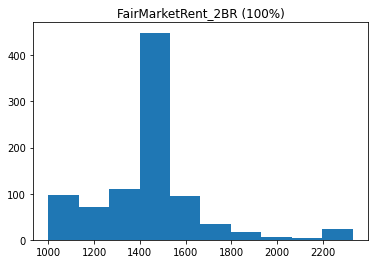

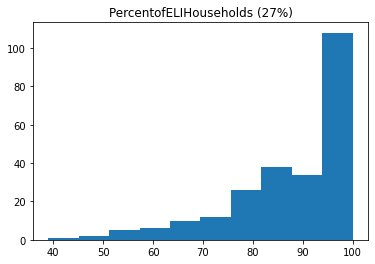

In [8]:
ic = [
    'TotalUnits',
    'FairMarketRent_2BR',
    'PercentofELIHouseholds',
]
for c in ic:
    fig, ax = plt.subplots()
    ax.hist(data_fl3[c][data_fl3[c].notnull()])
    pnn = data_fl3[c].notnull().mean()
    ax.set_title(f"{c} ({pnn:.0%})")
    display(fig)
    plt.close()

# Exploratory Data Analysis for Question 5

Research Question 5 (NHPD): Explore the National Housing Preservation Database, generating summary statistics and maps pertaining to low income housing in Florida. How does Florida compare to the rest of the Southeast, and how does it compare to the rest of the United States as a whole? (A few example questions to get you started: Does Florida reserve more units for certain protected groups compared to other locations? Are Florida units more likely to have received violations upon inspection? How does the proportion of units in each building reserved for low-income housing compare to other locations? Does fair market rent have any relation to the number of units available?)

## Subsidy Types in US vs. Three FL Counties

We want to compare the types of subsidies used in the US with these three FL counties in particular. For these purposes, we'll just count a property as having that subsidy if there is at least one subsidy of that type. We will aggregate over units (the `TotalUnits` column).

In [9]:
fraction_subsidies_df = pd.DataFrame()

fraction_subsidies = {}
total_number_of_units = data['TotalUnits'].sum()
for subsidy, column in active_subsidy_columns.items():
    fraction_subsidies[subsidy] = data['TotalUnits'][data[column] > 0].sum() / total_number_of_units
fraction_subsidies_df['US'] = pd.Series(fraction_subsidies)

fraction_subsidies_fl3 = {}
total_number_of_units_fl3 = data_fl3['TotalUnits'].sum()
for subsidy, column in active_subsidy_columns.items():
    fraction_subsidies_fl3[subsidy] = data_fl3['TotalUnits'][data_fl3[column] > 0].sum() / total_number_of_units_fl3
fraction_subsidies_df['FL3'] = pd.Series(fraction_subsidies_fl3)

fraction_subsidies_df.style.background_gradient(axis=None)

,US,FL3
Section8,0.290082,0.150988
Section202,0.005950,0.003622
Section236,0.001069,0.000000
HUDInsured,0.153180,0.112936
Lihtc,0.474398,0.584216
Section515,0.072207,0.010840
Section538,0.011328,0.000000
Home,0.110182,0.123594
PublicHousing,0.175303,0.108095
State,0.034796,0.465609


The big takeaway is that State subsidies are a much bigger category in these three FL counties.

## Target Tenant Types

Let's aggregate over the `TargetTenantType` column in a simpler way.

In [10]:
col = 'TargetTenantType'
fraction_ttt_df = pd.merge(
    data.groupby(col).agg(sum)['TotalUnits'] / data[data[col].notnull()]['TotalUnits'].sum(),
    data_fl3.groupby(col).agg(sum)['TotalUnits'] / data_fl3[data_fl3[col].notnull()]['TotalUnits'].sum(),
    left_index=True, right_index=True, how='left').rename(columns={'TotalUnits_x': 'US', 'TotalUnits_y': 'FL3'}).fillna(0)
fraction_ttt_df.style.background_gradient(axis=None)

,US,FL3
TargetTenantType,,
Congregate,0.000452,0.000000
Disabled,0.018835,0.007035
Elderly,0.264917,0.147066
Elderly Or Disabled,0.117720,0.048592
Family,0.548575,0.745616
Group Home,0.000098,0.000000
Health Care,0.000761,0.000119
Homeless,0.000456,0.006785
Low Income,0.000251,0.000000


So these three FL counties have even more Family housing (which is probably the default / most flexible value) than in the rest of the US. And less Elderly, despite Florida's reputation I guess.